/home/ubuntu/.local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to mult

Model loaded from /home/ubuntu/crf_alignment_model_best.pt

=== Benchmark with CRF, MUSCLE, best-of-CRF+MUSCLE, NW, SW ===

Pair 1/1508:
seq1: VAKYDYAAQGAQELDLRKNDRYLLLDDSKHWWRVQNNRNQSGYVPS
seq2: VAKYNFSADTNVELSLRKGDRIILLKRVDQNWYEGKIPGTNRQGIFPV

[CRF] Best alignment:
VAKYDYAAQGAQELDLRKNDRYLLLDDSKHWWRVQNN--RNQSGYVPS
||||   |    || ||| ||  ||      |        |  |  | 
VAKYNFSADTNVELSLRKGDRIILLKRVDQNWYEGKIPGTNRQGIFPV
Score: 186.34
Identity: 37.50%, Gaps: 4.17%

[MUSCLE] Alignment:
VAKYDYAAQGAQELDLRKNDRYLLLDD-SKHWWRVQ-NNRNQSGYVPS
||||   |    || ||| ||  ||      |        |  |  | 
VAKYNFSADTNVELSLRKGDRIILLKRVDQNWYEGKIPGTNRQGIFPV
Score: 18.00
Identity: 37.50%, Gaps: 4.17%

[CRF+MUSCLE] Best method is [CRF] with identity 37.50%
VAKYDYAAQGAQELDLRKNDRYLLLDDSKHWWRVQNN--RNQSGYVPS
||||   |    || ||| ||  ||      |        |  |  | 
VAKYNFSADTNVELSLRKGDRIILLKRVDQNWYEGKIPGTNRQGIFPV
Score: 186.34
Identity: 37.50%, Gaps: 4.17%

[Needleman-Wunsch] Alignment:
VAKYDYAAQGAQELDLRKNDRYLLL--DDSKHWWRVQNNRNQSGYVPS
|||

Method,percent_identity,gap_percentage,alignment_length
crf,30.25 ± 15.61,8.45 ± 10.13,73.78 ± 19.19
muscle,30.91 ± 15.23,10.50 ± 11.90,74.77 ± 19.99
crf+muscle,31.47 ± 14.99,10.09 ± 11.34,74.55 ± 19.79
needleman-wunsch,29.02 ± 16.39,8.28 ± 11.25,73.80 ± 19.44
smith-waterman,21.08 ± 18.67,23.10 ± 27.58,82.26 ± 27.13


/tmp/ipykernel_165935/2282570291.py:720: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


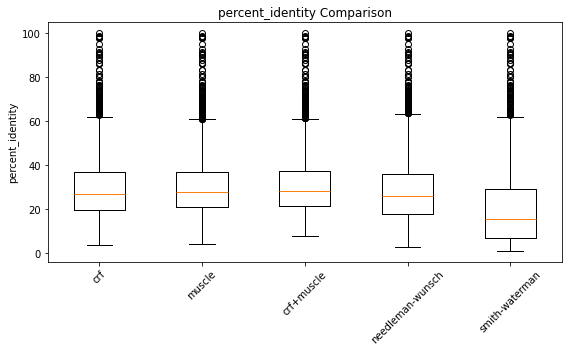

/tmp/ipykernel_165935/2282570291.py:720: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


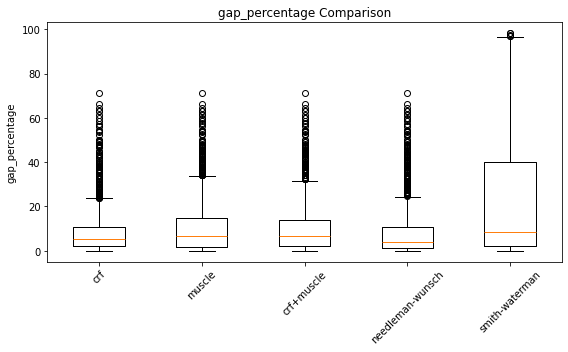

/tmp/ipykernel_165935/2282570291.py:720: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


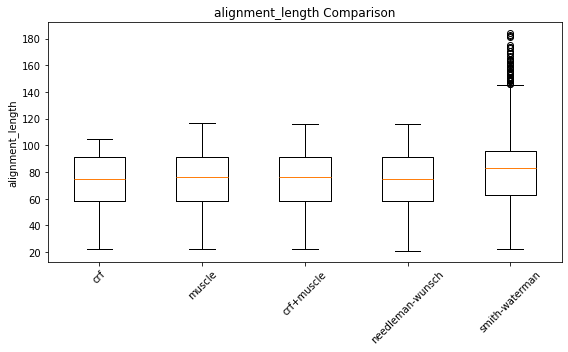

In [1]:
import os
import math
import random
from typing import List, Tuple, Dict, Optional
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# =====================
# Additional imports for stats, NW/SW, MUSCLE, plotting
# =====================
import logging
from pathlib import Path

# BioPython for pairwise alignment and FASTA parsing
from Bio import pairwise2
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from Bio import SeqIO

# For progress bars, plotting, and HTML tables
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from IPython.display import display, HTML
except ImportError:
    HTML = None

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# -----------------------------------------------------------------------------
# 1) Basic CRF Components
# -----------------------------------------------------------------------------
class SimpleEmbedder(nn.Module):
    """Embeds amino acids and computes pairwise match potentials"""
    def __init__(self, vocab_size=22, embed_dim=32, hidden_dim=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.gap_linear = nn.Parameter(torch.randn(1))
        
    def forward(self, seqA_idx: torch.Tensor, seqB_idx: torch.Tensor):
        embA = self.embed(seqA_idx)  # [lenA, embed_dim]
        embB = self.embed(seqB_idx)  # [lenB, embed_dim]
        
        lenA, lenB = embA.size(0), embB.size(0)
        embA_expanded = embA.unsqueeze(1).expand(lenA, lenB, -1)
        embB_expanded = embB.unsqueeze(0).expand(lenA, lenB, -1)
        
        pair_emb = torch.cat([embA_expanded, embB_expanded], dim=-1)
        match_matrix = self.linear(pair_emb).squeeze(-1)
        return match_matrix, self.gap_linear


class PairwiseAlignmentCRF(nn.Module):
    """
    3-state CRF for M=0, I=1, D=2 with transition[i,j] = cost from i->j.
    """
    def __init__(self):
        super().__init__()
        self.transition = nn.Parameter(torch.zeros(3, 3))
        nn.init.uniform_(self.transition, -1.0, 0.0)

    def viterbi_decode(self, match_matrix: torch.Tensor, gap_score: torch.Tensor):
        """
        Returns (best_score, path_states), where path_states is (state, i, j).
        """
        device = match_matrix.device
        lenA, lenB = match_matrix.shape
        M, I, D = 0, 1, 2
        T = self.transition
        NEG_INF = float('-inf')

        dp_M = torch.full((lenA+1, lenB+1), NEG_INF, device=device)
        dp_I = torch.full((lenA+1, lenB+1), NEG_INF, device=device)
        dp_D = torch.full((lenA+1, lenB+1), NEG_INF, device=device)

        bp_M = torch.zeros((lenA+1, lenB+1), dtype=torch.long, device=device)
        bp_I = torch.zeros((lenA+1, lenB+1), dtype=torch.long, device=device)
        bp_D = torch.zeros((lenA+1, lenB+1), dtype=torch.long, device=device)

        dp_M[0,0] = 0.0

        for i in range(lenA+1):
            for j in range(lenB+1):
                if i == 0 and j == 0:
                    continue

                # M
                if i > 0 and j > 0:
                    score_match = match_matrix[i-1,j-1]
                    candidates = torch.stack([
                        dp_M[i-1,j-1] + T[M,M] + score_match,
                        dp_I[i-1,j-1] + T[I,M] + score_match,
                        dp_D[i-1,j-1] + T[D,M] + score_match
                    ])
                    best_val, best_idx = torch.max(candidates, dim=0)
                    dp_M[i,j] = best_val
                    bp_M[i,j] = best_idx

                # I
                if i > 0:
                    candidates = torch.stack([
                        dp_M[i-1,j] + T[M,I] + gap_score,
                        dp_I[i-1,j] + T[I,I] + gap_score,
                        dp_D[i-1,j] + T[D,I] + gap_score
                    ])
                    best_val, best_idx = torch.max(candidates, dim=0)
                    dp_I[i,j] = best_val
                    bp_I[i,j] = best_idx

                # D
                if j > 0:
                    candidates = torch.stack([
                        dp_M[i,j-1] + T[M,D] + gap_score,
                        dp_I[i,j-1] + T[I,D] + gap_score,
                        dp_D[i,j-1] + T[D,D] + gap_score
                    ])
                    best_val, best_idx = torch.max(candidates, dim=0)
                    dp_D[i,j] = best_val
                    bp_D[i,j] = best_idx

        final_scores = torch.stack([dp_M[lenA,lenB], dp_I[lenA,lenB], dp_D[lenA,lenB]])
        best_final_score, best_state = torch.max(final_scores, dim=0)

        # Backtrack
        path_states = []
        i, j = lenA, lenB
        cur_state = best_state.item()

        while not (i == 0 and j == 0):
            path_states.append((cur_state, i, j))
            if cur_state == M:
                prev_state = bp_M[i,j].item()
                i, j = i-1, j-1
                cur_state = prev_state
            elif cur_state == I:
                prev_state = bp_I[i,j].item()
                i = i-1
                cur_state = prev_state
            else:  # D
                prev_state = bp_D[i,j].item()
                j = j-1
                cur_state = prev_state

        path_states.reverse()
        return best_final_score, path_states


# -----------------------------------------------------------------------------
# 2) CRFAlignmentModel
# -----------------------------------------------------------------------------
class CRFAlignmentModel(nn.Module):
    """Base CRF model for sequence alignment with correct architecture"""
    def __init__(self, vocab_size=22, embed_dim=32, hidden_dim=64):
        super().__init__()
        self.embedder = SimpleEmbedder(vocab_size, embed_dim, hidden_dim)
        self.crf = PairwiseAlignmentCRF()

    def forward(self, seqA_idx, seqB_idx):
        match_matrix, gap_score = self.embedder(seqA_idx, seqB_idx)
        return match_matrix, gap_score

    def viterbi_decode(self, seqA_idx, seqB_idx):
        """Return best path via Viterbi decode."""
        match_matrix, gap_score = self.embedder(seqA_idx, seqB_idx)
        return self.crf.viterbi_decode(match_matrix, gap_score)


# -----------------------------------------------------------------------------
# 3) EnhancedCRFAligner
# -----------------------------------------------------------------------------
class EnhancedCRFAligner:
    """
    Enhanced CRF aligner with optional refinements. 
    Anchor detection is disabled by setting anchors=[] after call.
    """
    def __init__(
        self,
        model: CRFAlignmentModel,
        device='cpu',
        transition_amplitude=0.25,
        embed_amplitude=0.15,
        temperature_range=(0.5, 2.0),
        beam_width=5,
        min_anchor_length=3,  # Minimum length for anchor blocks
        max_refinement_iterations=3  # Max iterations for refinement
    ):
        self.model = model.to(device)
        self.device = device
        self.vocab = {
            'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7,
            'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
            'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, '-': 20, '<pad>': 21
        }
        self.transition_amplitude = transition_amplitude
        self.embed_amplitude = embed_amplitude
        self.temperature_range = temperature_range
        self.beam_width = beam_width
        self.min_anchor_length = min_anchor_length
        self.max_refinement_iterations = max_refinement_iterations

    def find_anchor_blocks(self, seq1: str, seq2: str) -> List[Tuple[int, int, int]]:
        """
        Normally identifies anchor blocks. 
        We disable anchor usage later by forcibly setting anchors=[].
        """
        anchors = []
        len1, len2 = len(seq1), len(seq2)
        
        for i in range(len1 - self.min_anchor_length + 1):
            window1 = seq1[i:i + self.min_anchor_length]
            for j in range(len2 - self.min_anchor_length + 1):
                window2 = seq2[j:j + self.min_anchor_length]
                if window1 == window2:
                    # try to extend
                    k = 0
                    while (i + self.min_anchor_length + k < len1 and 
                           j + self.min_anchor_length + k < len2 and
                           seq1[i + self.min_anchor_length + k] == 
                           seq2[j + self.min_anchor_length + k]):
                        k += 1
                    anchors.append((i, j, self.min_anchor_length + k))
        
        anchors.sort(key=lambda x: x[2], reverse=True)
        filtered_anchors = []
        used_positions = set()
        
        for start1, start2, length in anchors:
            positions1 = set(range(start1, start1 + length))
            # skip if overlap
            if not (positions1 & used_positions):
                filtered_anchors.append((start1, start2, length))
                used_positions.update(positions1)
        
        return sorted(filtered_anchors, key=lambda x: x[0])

    def compute_adaptive_gap_penalties(
        self,
        seq1: str,
        seq2: str,
        anchors: List[Tuple[int, int, int]]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute position-specific gap penalties based on sequence context
        and anchor positions. But anchor-based won't matter if anchors=[].
        """
        len1, len2 = len(seq1), len(seq2)
        gap_penalties1 = torch.ones(len1, device=self.device)
        gap_penalties2 = torch.ones(len2, device=self.device)
        
        # If anchors list is empty, no anchor-based boosting will happen.
        for start1, start2, length in anchors:
            buffer = 2
            for i in range(max(0, start1 - buffer), min(len1, start1 + length + buffer)):
                gap_penalties1[i] *= 1.5
            for i in range(max(0, start2 - buffer), min(len2, start2 + length + buffer)):
                gap_penalties2[i] *= 1.5

        # Adjust by residue type
        for i, aa in enumerate(seq1):
            if aa in 'GPNS':  # flexible
                gap_penalties1[i] *= 0.8
            elif aa in 'FILMVW':  # more hydrophobic
                gap_penalties1[i] *= 1.2
                
        for i, aa in enumerate(seq2):
            if aa in 'GPNS':
                gap_penalties2[i] *= 0.8
            elif aa in 'FILMVW':
                gap_penalties2[i] *= 1.2
        
        return gap_penalties1, gap_penalties2

    def refine_alignment(
        self,
        seq1: str,
        seq2: str,
        initial_alignment: Tuple[str, str],
        score: float
    ) -> Tuple[str, str, float]:
        """
        Iteratively refine alignment by local re-alignment of problem regions.
        """
        best_aligned1, best_aligned2 = initial_alignment
        best_score = score
        
        for _ in range(self.max_refinement_iterations):
            aligned1, aligned2 = best_aligned1, best_aligned2
            window_size = 10
            problem_regions = []
            
            for i in range(0, len(aligned1) - window_size + 1):
                window1 = aligned1[i:i + window_size]
                window2 = aligned2[i:i + window_size]
                matches = sum(a == b for a, b in zip(window1, window2))
                if matches < window_size * 0.5:
                    problem_regions.append((i, i + window_size))
            
            merged_regions = []
            if problem_regions:
                current_start, current_end = problem_regions[0]
                for start, end in problem_regions[1:]:
                    if start <= current_end + 3:
                        current_end = end
                    else:
                        merged_regions.append((current_start, current_end))
                        current_start, current_end = start, end
                merged_regions.append((current_start, current_end))
            
            improved = False
            for start, end in merged_regions:
                orig1 = ''.join(c for c in aligned1[start:end] if c != '-')
                orig2 = ''.join(c for c in aligned2[start:end] if c != '-')
                
                sub_aligned1, sub_aligned2, sub_score = self.align_subsequence(orig1, orig2)
                
                orig_matches = sum(a == b for a, b in zip(aligned1[start:end], aligned2[start:end]))
                new_matches = sum(a == b for a, b in zip(sub_aligned1, sub_aligned2))
                
                if new_matches > orig_matches:
                    improved = True
                    best_aligned1 = best_aligned1[:start] + sub_aligned1 + best_aligned1[end:]
                    best_aligned2 = best_aligned2[:start] + sub_aligned2 + best_aligned2[end:]
            
            if not improved:
                break
                
        return best_aligned1, best_aligned2, best_score

    def align_subsequence(
        self,
        seq1: str,
        seq2: str
    ) -> Tuple[str, str, float]:
        """Align a pair of subsequences with a small tweak to match/gap."""
        seq1_idx = torch.tensor(
            [self.vocab.get(a, self.vocab['<pad>']) for a in seq1],
            dtype=torch.long,
            device=self.device
        )
        seq2_idx = torch.tensor(
            [self.vocab.get(b, self.vocab['<pad>']) for b in seq2],
            dtype=torch.long,
            device=self.device
        )
        
        with torch.no_grad():
            match_matrix, gap_score = self.model(seq1_idx, seq2_idx)
            
        # Example tweak
        match_matrix = match_matrix * 1.2
        gap_score = gap_score * 0.9
        
        score, path = self.model.viterbi_decode(seq1_idx, seq2_idx)
        aligned1, aligned2 = self._reconstruct_alignment(seq1, seq2, path)
        return aligned1, aligned2, float(score.item())

    def align(
        self,
        seq1: str,
        seq2: str,
        n_samples: int = 5,
        return_metrics: bool = True
    ) -> List[Tuple[str, str, float, Dict[str, float]]]:
        """
        Enhanced alignment procedure. 
        We find anchors, then forcibly set anchors=[] to disable anchor usage.
        """
        anchors = self.find_anchor_blocks(seq1, seq2)
        anchors = []  # disable anchor-based usage

        seq1_idx = torch.tensor(
            [self.vocab.get(a, self.vocab['<pad>']) for a in seq1],
            dtype=torch.long,
            device=self.device
        )
        seq2_idx = torch.tensor(
            [self.vocab.get(b, self.vocab['<pad>']) for b in seq2],
            dtype=torch.long,
            device=self.device
        )
        
        gap_penalties1, gap_penalties2 = self.compute_adaptive_gap_penalties(seq1, seq2, anchors)
        
        results = []
        with torch.no_grad():
            match_matrix, gap_score = self.model(seq1_idx, seq2_idx)
            
            # multiply gap_score by average gap penalty
            gap_score = gap_score * torch.min(gap_penalties1.mean(), gap_penalties2.mean())
            
            # initial alignment
            score, path = self.model.viterbi_decode(seq1_idx, seq2_idx)
            aligned1, aligned2 = self._reconstruct_alignment(seq1, seq2, path)
            
            # refinement
            refined1, refined2, refined_score = self.refine_alignment(
                seq1, seq2, (aligned1, aligned2), float(score.item())
            )
            
            if return_metrics:
                metrics = self.calculate_alignment_metrics(refined1, refined2)
                results.append((refined1, refined2, refined_score, metrics, "enhanced"))
            
            # random perturbations
            for _ in range(n_samples - 1):
                identity = sum(a == b for a, b in zip(refined1, refined2)) / max(1, len(refined1))
                perturbed_transition = self.perturb_parameters(self.transition_amplitude, identity)
                self.model.crf.transition.copy_(perturbed_transition)
                
                score2, path2 = self.model.viterbi_decode(seq1_idx, seq2_idx)
                a1b, a2b = self._reconstruct_alignment(seq1, seq2, path2)
                
                refined_a1, refined_a2, refined_score2 = self.refine_alignment(
                    seq1, seq2, (a1b, a2b), float(score2.item())
                )
                
                if return_metrics:
                    metrics2 = self.calculate_alignment_metrics(refined_a1, refined_a2)
                    results.append((refined_a1, refined_a2, refined_score2, metrics2, "perturbed"))
        
        # sort by identity or score, return best
        if return_metrics:
            results.sort(key=lambda x: x[3]['percent_identity'], reverse=True)
        else:
            results.sort(key=lambda x: x[2], reverse=True)
        
        return [(r[0], r[1], r[2], r[3]) for r in results[:1]]

    def _reconstruct_alignment(
        self,
        seqA: str,
        seqB: str,
        path_states: List[Tuple[int,int,int]]
    ) -> Tuple[str, str]:
        alignedA, alignedB = [], []
        M, I, D = 0, 1, 2
        
        for (st, i, j) in path_states:
            if st == M:
                alignedA.append(seqA[i-1])
                alignedB.append(seqB[j-1])
            elif st == I:
                alignedA.append(seqA[i-1])
                alignedB.append('-')
            else:  # D
                alignedA.append('-')
                alignedB.append(seqB[j-1])
                
        return ''.join(alignedA), ''.join(alignedB)

    def calculate_alignment_metrics(
        self,
        aligned1: str,
        aligned2: str
    ) -> Dict[str, float]:
        if len(aligned1) != len(aligned2):
            raise ValueError("Aligned sequences must have the same length")
            
        length = len(aligned1)
        matches = sum(a == b for a,b in zip(aligned1, aligned2))
        gaps = sum(a == '-' or b == '-' for a,b in zip(aligned1, aligned2))
        
        gap_runs = 0
        in_gap = False
        for a, b in zip(aligned1, aligned2):
            if a == '-' or b == '-':
                if not in_gap:
                    gap_runs += 1
                    in_gap = True
            else:
                in_gap = False
        
        # Count windows of high conservation
        window_size = 5
        conserved_windows = 0
        total_windows = length - window_size + 1
        for i in range(total_windows):
            window_matches = sum(aligned1[i+j] == aligned2[i+j] for j in range(window_size))
            if window_matches >= window_size * 0.8:
                conserved_windows += 1
        
        # Motif analysis: check 3-residue exact matches
        motif_matches = 0
        motif_size = 3
        for i in range(length - motif_size + 1):
            motif1 = aligned1[i:i+motif_size]
            motif2 = aligned2[i:i+motif_size]
            if motif1 == motif2 and '-' not in motif1:
                motif_matches += 1
        
        conservation_ratio = 0.0
        if total_windows > 0:
            conservation_ratio = conserved_windows / total_windows
        
        eff_id = 0.0
        if length > gaps:
            eff_id = (matches / (length - gaps)) * 100
        
        return {
            'percent_identity': (matches / length) * 100,
            'gap_percentage': (gaps / length) * 100,
            'alignment_length': length,
            'matches': matches,
            'gaps': gaps,
            'gap_runs': gap_runs,
            'conserved_windows': conserved_windows,
            'conservation_ratio': conservation_ratio,
            'motif_matches': motif_matches,
            'motif_density': motif_matches / max(1, length - motif_size + 1),
            'effective_identity': eff_id
        }

    def perturb_parameters(
        self,
        amplitude: float,
        similarity_factor: float
    ) -> torch.Tensor:
        # amplitude scaled by (1 - similarity_factor)
        adjusted_amplitude = amplitude * (1.0 - similarity_factor)
        random_state = torch.rand_like(self.model.crf.transition) * 2 - 1
        
        match_boost = torch.zeros_like(self.model.crf.transition)
        match_boost[0, 0] = 1.0  # M->M
        gap_flexibility = torch.zeros_like(self.model.crf.transition)
        gap_flexibility[1:, 1:] = 0.5  # I->I, D->D

        pattern_mix = similarity_factor * match_boost + (1 - similarity_factor) * gap_flexibility
        
        perturbed = self.model.crf.transition * (
            1 + adjusted_amplitude * (0.7 * random_state + 0.3 * pattern_mix)
        )
        return F.softmax(perturbed, dim=-1)

    def beam_search_decode(
        self,
        match_matrix: torch.Tensor,
        gap_score: torch.Tensor,
        temperature: float = 1.0,
        max_beam_width: int = 5
    ) -> List[Tuple[float, List[Tuple[int,int,int]]]]:
        """
        Alternative beam search approach (not used by default).
        """
        device = match_matrix.device
        lenA, lenB = match_matrix.shape
        M, I, D = 0, 1, 2
        
        match_matrix = match_matrix / temperature
        gap_score = gap_score / temperature
        T = self.model.crf.transition / temperature

        BeamState = Tuple[float, int, int, int, List[Tuple[int,int,int]]]
        beam: List[BeamState] = [(0.0, M, 0, 0, [])]

        match_density = torch.zeros((lenA, lenB), device=device)
        window_size = 3
        
        # local average match to adapt beam width
        for i in range(lenA):
            for j in range(lenB):
                start_i = max(0, i - window_size)
                end_i = min(lenA, i + window_size + 1)
                start_j = max(0, j - window_size)
                end_j = min(lenB, j + window_size + 1)
                window = match_matrix[start_i:end_i, start_j:end_j]
                match_density[i, j] = torch.mean(window)

        for _ in range(lenA + lenB):
            candidates = []
            for log_prob, state, i, j, history in beam:
                if i == lenA and j == lenB:
                    candidates.append((log_prob, state, i, j, history))
                    continue

                current_density = match_density[min(i, lenA-1), min(j, lenB-1)]
                local_beam_width = min(max_beam_width, max(2, int(max_beam_width * current_density)))

                if i < lenA and j < lenB:
                    context_bonus = 0.1 * current_density
                    score = match_matrix[i,j] + T[state,M] + context_bonus
                    candidates.append((log_prob + score, M, i+1, j+1, history + [(M,i,j)]))

                if i < lenA:
                    penalty = 0.1 * (1 - current_density)
                    score = gap_score + T[state,I] - penalty
                    candidates.append((log_prob + score, I, i+1, j, history + [(I,i,j)]))

                if j < lenB:
                    penalty = 0.1 * (1 - current_density)
                    score = gap_score + T[state,D] - penalty
                    candidates.append((log_prob + score, D, i, j+1, history + [(D,i,j)]))

            if candidates:
                candidates.sort(key=lambda x: x[0], reverse=True)
                beam = candidates[:local_beam_width]
                if all(i == lenA and j == lenB for _, _, i, j, _ in beam):
                    break

        return [(score, path) for score, _, _, _, path in beam if path]


def visualize_alignment(seq1: str, seq2: str, score: float):
    """Pretty-print an alignment with match indicators"""
    print(seq1)
    print(''.join('|' if a == b else ' ' for a,b in zip(seq1, seq2)))
    print(seq2)
    print(f"Score: {score:.2f}")


# -----------------------------------------------------------------------------
# 5) MUSCLE Aligner + NW/SW + Utility
# -----------------------------------------------------------------------------
class MuscleAligner:
    """
    Calls MUSCLE to produce (aligned1, aligned2, simple_score).
    """
    def __init__(self, muscle_exe="muscle"):
        self.muscle_exe = muscle_exe

    def align(self, seq1: str, seq2: str) -> List[Tuple[str, str, float]]:
        import tempfile
        with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.fasta') as f_in, \
             tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.fasta') as f_out:

            f_in.write(f">seq1\n{seq1}\n>seq2\n{seq2}\n")
            f_in.flush()

            muscle_cline = MuscleCommandline(self.muscle_exe, input=f_in.name, out=f_out.name)
            try:
                stdout, stderr = muscle_cline()
            except Exception as e:
                logger.warning(f"MUSCLE alignment failed: {e}")
                os.unlink(f_in.name)
                os.unlink(f_out.name)
                return []

            # parse
            try:
                alignment = AlignIO.read(f_out.name, "fasta")
                aligned1 = str(alignment[0].seq)
                aligned2 = str(alignment[1].seq)
                score = sum(a == b for a,b in zip(aligned1, aligned2))
                os.unlink(f_in.name)
                os.unlink(f_out.name)
                return [(aligned1, aligned2, float(score))]
            except Exception as e:
                logger.warning(f"Failed to parse MUSCLE output: {e}")
                os.unlink(f_in.name)
                os.unlink(f_out.name)
                return []


def calculate_alignment_metrics(seq1: str, seq2: str) -> Dict[str, float]:
    """
    Check alignment length, # matches => percent_identity, # gaps => gap_percentage, etc.
    """
    if len(seq1) != len(seq2):
        raise ValueError("Aligned sequences must have the same length.")
    length = len(seq1)
    matches = sum(a==b for a,b in zip(seq1, seq2))
    gaps = sum(a=='-' or b=='-' for a,b in zip(seq1, seq2))
    return {
        'percent_identity': (matches/length)*100,
        'gap_percentage': (gaps/length)*100,
        'alignment_length': length
    }


def create_summary_table(results: Dict[str, List[Dict[str, float]]]) -> HTML:
    """
    Build an HTML table summarizing mean±std of each metric, for each method.
    Falls back to plain text if HTML is not available.
    """
    if not results:
        return HTML("<p>No results to display.</p>")
    methods = list(results.keys())
    metrics = list(results[methods[0]][0].keys()) if results[methods[0]] else []

    html = "<table style='border-collapse: collapse; width: 100%;'>"
    html += "<tr><th style='border:1px solid black; padding:8px;'>Method</th>"
    for metric in metrics:
        html += f"<th style='border:1px solid black; padding:8px;'>{metric}</th>"
    html += "</tr>"

    for m in methods:
        html += f"<tr><td style='border:1px solid black; padding:8px;'>{m}</td>"
        vals_list = results[m]
        for metric in metrics:
            arr = [v[metric] for v in vals_list]
            mean_val = np.mean(arr) if len(arr) > 0 else 0
            std_val = np.std(arr) if len(arr) > 1 else 0
            html += f"<td style='border:1px solid black; padding:8px;'>{mean_val:.2f} ± {std_val:.2f}</td>"
        html += "</tr>"

    html += "</table>"
    return HTML(html)


def plot_metric_comparison(results: Dict[str, List[Dict[str, float]]], metric: str):
    """Boxplot of the chosen metric across alignment methods."""
    plt.figure(figsize=(8,5))
    data = []
    labels = []
    for method, vals_list in results.items():
        arr = [v[metric] for v in vals_list]
        data.append(arr)
        labels.append(method)
    plt.boxplot(data, labels=labels)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# 6) run_benchmark
# -----------------------------------------------------------------------------
def run_benchmark(aligner: EnhancedCRFAligner, test_pairs: List[Tuple[str, str]]):
    """
    Run benchmark on multiple test sequence pairs using:
      1) CRF,
      2) MUSCLE,
      3) best-of-CRF+MUSCLE,
      4) Needleman-Wunsch,
      5) Smith-Waterman.
    """
    results = defaultdict(list)
    muscle_aligner = MuscleAligner()  # for MUSCLE alignment

    print("\n=== Benchmark with CRF, MUSCLE, best-of-CRF+MUSCLE, NW, SW ===")
    for idx, (seq1, seq2) in enumerate(test_pairs):
        print(f"\nPair {idx+1}/{len(test_pairs)}:")
        print(f"seq1: {seq1}")
        print(f"seq2: {seq2}")

        # ---------------------------
        # 1) CRF alignment
        # ---------------------------
        crf_a1, crf_a2, crf_score, _crf_metrics = ("", "", 0.0, {})
        alignments = aligner.align(seq1, seq2, n_samples=5)
        if alignments:
            crf_a1, crf_a2, crf_score, _crf_metrics = alignments[0]
            print("\n[CRF] Best alignment:")
            visualize_alignment(crf_a1, crf_a2, crf_score)
            mm_crf = calculate_alignment_metrics(crf_a1, crf_a2)
            print(f"Identity: {mm_crf['percent_identity']:.2f}%, Gaps: {mm_crf['gap_percentage']:.2f}%")
            results['crf'].append(mm_crf)
        else:
            results['crf'].append({'percent_identity': 0, 'gap_percentage': 0, 'alignment_length': 0})

        # ---------------------------
        # 2) MUSCLE
        # ---------------------------
        mus_a1, mus_a2, mus_score, mm_muscle = ("", "", 0.0, {})
        muscle_res = muscle_aligner.align(seq1, seq2)
        if muscle_res:
            mus_a1, mus_a2, mus_score = muscle_res[0]
            print("\n[MUSCLE] Alignment:")
            visualize_alignment(mus_a1, mus_a2, mus_score)
            mm_muscle = calculate_alignment_metrics(mus_a1, mus_a2)
            print(f"Identity: {mm_muscle['percent_identity']:.2f}%, Gaps: {mm_muscle['gap_percentage']:.2f}%")
            results['muscle'].append(mm_muscle)
        else:
            results['muscle'].append({'percent_identity': 0, 'gap_percentage': 0, 'alignment_length': 0})

        # ---------------------------
        # 3) best of CRF+MUSCLE
        # ---------------------------
        crf_identity = results['crf'][-1]['percent_identity']
        muscle_identity = results['muscle'][-1]['percent_identity']
        if crf_identity >= muscle_identity:
            best_a1, best_a2 = crf_a1, crf_a2
            best_score = crf_score
            best_metrics = results['crf'][-1]
            method_chosen = "[CRF]"
        else:
            best_a1, best_a2 = mus_a1, mus_a2
            best_score = mus_score
            best_metrics = results['muscle'][-1]
            method_chosen = "[MUSCLE]"

        print(f"\n[CRF+MUSCLE] Best method is {method_chosen} with identity {best_metrics['percent_identity']:.2f}%")
        visualize_alignment(best_a1, best_a2, best_score)
        print(f"Identity: {best_metrics['percent_identity']:.2f}%, Gaps: {best_metrics['gap_percentage']:.2f}%")
        results['crf+muscle'].append(best_metrics)

        # ---------------------------
        # 4) Needleman-Wunsch
        # ---------------------------
        try:
            nw_alignments = pairwise2.align.globalms(seq1, seq2, 1, -1, -10, -0.5)
            if nw_alignments:
                nw_a1, nw_a2, nw_sc, _, _ = nw_alignments[0]
                print("\n[Needleman-Wunsch] Alignment:")
                visualize_alignment(nw_a1, nw_a2, nw_sc)
                mm_nw = calculate_alignment_metrics(nw_a1, nw_a2)
                print(f"Identity: {mm_nw['percent_identity']:.2f}%, Gaps: {mm_nw['gap_percentage']:.2f}%")
                results['needleman-wunsch'].append(mm_nw)
            else:
                results['needleman-wunsch'].append({'percent_identity': 0, 'gap_percentage': 0, 'alignment_length': 0})
        except Exception as e:
            logger.warning(f"NW alignment error: {e}")
            results['needleman-wunsch'].append({'percent_identity': 0, 'gap_percentage': 0, 'alignment_length': 0})

        # ---------------------------
        # 5) Smith-Waterman
        # ---------------------------
        try:
            sw_alignments = pairwise2.align.localms(seq1, seq2, 1, -1, -10, -0.5)
            if sw_alignments:
                sw_a1, sw_a2, sw_sc, start, end = sw_alignments[0]
                print("\n[Smith-Waterman] Alignment:")
                visualize_alignment(sw_a1, sw_a2, sw_sc)
                mm_sw = calculate_alignment_metrics(sw_a1, sw_a2)
                print(f"Identity: {mm_sw['percent_identity']:.2f}%, Gaps: {mm_sw['gap_percentage']:.2f}%")
                results['smith-waterman'].append(mm_sw)
            else:
                results['smith-waterman'].append({'percent_identity': 0, 'gap_percentage': 0, 'alignment_length': 0})
        except Exception as e:
            logger.warning(f"SW alignment error: {e}")
            results['smith-waterman'].append({'percent_identity': 0, 'gap_percentage': 0, 'alignment_length': 0})

    # ---------------------------
    # Summaries
    # ---------------------------
    print("\n===== Summary Statistics =====")
    summary_html = create_summary_table(results)
    if HTML and isinstance(summary_html, HTML):
        display(summary_html)
    else:
        # fallback: print plain text summary
        methods = list(results.keys())
        for m in methods:
            ms = results[m]
            if not ms:
                continue
            print(f"\nMethod: {m}  (N={len(ms)})")
            for metric in ms[0].keys():
                vals = [d[metric] for d in ms]
                mean_val = np.mean(vals) if len(vals) > 0 else 0
                std_val = np.std(vals) if len(vals) > 1 else 0
                print(f" {metric}: {mean_val:.2f} ± {std_val:.2f}")

    for metric in ["percent_identity", "gap_percentage", "alignment_length"]:
        plot_metric_comparison(results, metric)


# -----------------------------------------------------------------------------
# 7) Data loading for Balifam structure
# -----------------------------------------------------------------------------
def load_balifam100_pairs(
    base_dir: str = "balifam-main/balifam100"
) -> List[Tuple[str, str]]:
    """
    1) Reads the list of IDs from `<base_dir>/info/ids.txt`.
    2) For each ID, parses the file `<base_dir>/in/<ID>` (e.g. `PF00009.100`).
       - Extracts all FASTA sequences **only if** length < 80.
       - Forms consecutive pairs: (seq0, seq1), (seq2, seq3), ...
    3) Returns a list of (seqA, seqB) pairs across all files.
    """
    info_file = os.path.join(base_dir, "info", "ids.txt")
    in_dir = os.path.join(base_dir, "in")

    all_pairs = []
    try:
        with open(info_file, "r") as f:
            ids = [line.strip() for line in f if line.strip()]  # e.g. PF00009.100
    except Exception as e:
        logger.error(f"Could not read ids.txt from {info_file}: {e}")
        return all_pairs

    for set_id in ids:
        # No .fasta extension! Use the ID exactly as in the file name:
        fasta_path = os.path.join(in_dir, set_id)
        
        if not os.path.exists(fasta_path):
            logger.warning(f"FASTA file missing: {fasta_path}")
            continue
        
        # read sequences only if length < 80
        seqs = []
        try:
            for record in SeqIO.parse(fasta_path, "fasta"):
                seq_str = str(record.seq).upper()
                if len(seq_str) < 100:  # <--- Only keep sequences < 80 residues
                    seqs.append(seq_str)
        except Exception as e:
            logger.warning(f"Could not parse {fasta_path}: {e}")
            continue

        # form consecutive pairs: (seq0, seq1), (seq2, seq3), ...
        for i in range(0, len(seqs), 2):
            if i + 1 < len(seqs):
                pair = (seqs[i], seqs[i+1])
                all_pairs.append(pair)

    return all_pairs


# -----------------------------------------------------------------------------
# 8) main()
# -----------------------------------------------------------------------------
def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Initialize model
    model = CRFAlignmentModel(vocab_size=22, embed_dim=32, hidden_dim=64)
    aligner = EnhancedCRFAligner(
        model,
        device=device,
        min_anchor_length=3,
        max_refinement_iterations=3
    )
    
    # Optionally load a checkpoint if available
    checkpoint_path = '/home/ubuntu/crf_alignment_model_best.pt'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        aligner.model.load_state_dict(checkpoint)
        aligner.model.eval()
        print(f"Model loaded from {checkpoint_path}")

    # Load pairs from balifam100, but only sequences < 80 residues
    test_pairs = load_balifam100_pairs("balifam-main/balifam100")
    if not test_pairs:
        print("No sequence pairs found (or none <80 AA). Please check the Balifam data structure.")
        return

    # Run benchmark
    run_benchmark(aligner, test_pairs)


if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    main()
